**Sparse functional principal components analysis (SFPCA) for sparse longitudinal data analysis**

"**Sparse**" means samples collected at irregular timing and frequency across subjects.

Goals of SFPCA: 
* estimate **smooth mean trajectories** (most longitudinal methods do)
* estimate **smooth principal modes of variation of subject-level trajectories** around the mean trajectory (most longitudinal methods lack)

Let $Y_i (t)$ be the measurement at time $t$ for the $i$th individual, $\mu(t)$ the overall mean function, 

$f_j$ the $j$th principal component function and $k$ is the number of principal components.

Then the SFPCA model is given by

\begin{equation}
    Y_i(t) = \mu(t) + \sum_{j=1}^{k}f_j(t) \alpha_{ij} + \epsilon_i(t), \quad i = 1, ..., N
\end{equation}

**Model selection**:
* number of principal components $k$ (typically range from 1 to 4)
* number of interal nodes for spline basis when using cubic spline to approximate $\mu(t)$ and $f_j(t)$ (typically range from 1 to 3)

**Normality assumptions**:

* $\alpha_{ij}$ is a normally-distributed component weights for the $i$th individual

* $\epsilon_i (t)$ is a normally-distributed residual, independent across subjects and across times within subject

**Bayesian SFPCA**:

* use PSIS-LOO (leave-one-out cross-validation (LOO) with Pareto-smoothed importance sampling (PSIS) for model selection 
* use two graphical model diagnostic tools (PSIS-LOO k diagnostics plot and visual posterior checks) for model checking
* enable automatic SFPCA application and careful examination of optimal model in real longiutidnal data analysis to ensure valid inference
* implemented in [BayesTime R package on biocore](https://github.com/biocore/bayestime)
* BayesTime package available on **kl-jupyter kernel R_3.6.3-9.3.0** & **barnacle Module R_3.6.3-9.3.0**
* demonstrate the usage of BayesTime on microbiome longitudinal data analysis using a skin microbiome dataset (Bouslimani et al. 2019, BMC biology)



In [1]:
# load package and set global seed
library(BayesTime)
set.seed(31)

Loading required package: ggplot2



requirements of input data:
* long format (each row represents a sample at each time point, not a subject);
* required variables: 
    1. unique subject identifier to identify the samples related to the same subject
    2. time variable to indicate collection time of samples (can be unevenly and vary across subjects)
    3. response variable to record value of measurements
    4. additional baseline covariates interested for inferring group difference (require time-invarying covariates)

In [3]:
# read in longitudinal dataset
df = read.csv("data_skin_microbiome.txt", sep='\t')
head(df)

,X.SampleID,subject,timepoint,shannon_alpha,sample_site,sex,ID_unique,shannon_avg
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,10370.1A10,Volunteer 1,0,6.382872,Armpit,female,Volunteer 1Armpit,5.568020
2,10370.4A10,Volunteer 1,1,2.261372,Armpit,female,Volunteer 1Armpit,2.261372
3,10370.6A12,Volunteer 1,2,4.406199,Armpit,female,Volunteer 1Armpit,4.406199
4,10370.8C2,Volunteer 1,3,2.280323,Armpit,female,Volunteer 1Armpit,2.227507
5,10370.13E10,Volunteer 1,5,4.857540,Armpit,female,Volunteer 1Armpit,4.857540
6,10370.15G4,Volunteer 1,6,6.202666,Armpit,female,Volunteer 1Armpit,6.202666


visualize original data to observe original data:
* get a brief idea about possible range of PCs and number of internal knots:
    * the more each curves are different from each other, the higher the number of PCs
    * the more the shifts in curves over time, the higher the number of internal knots
* check whether group difference exists for interested covariate
* spot potential outliers

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



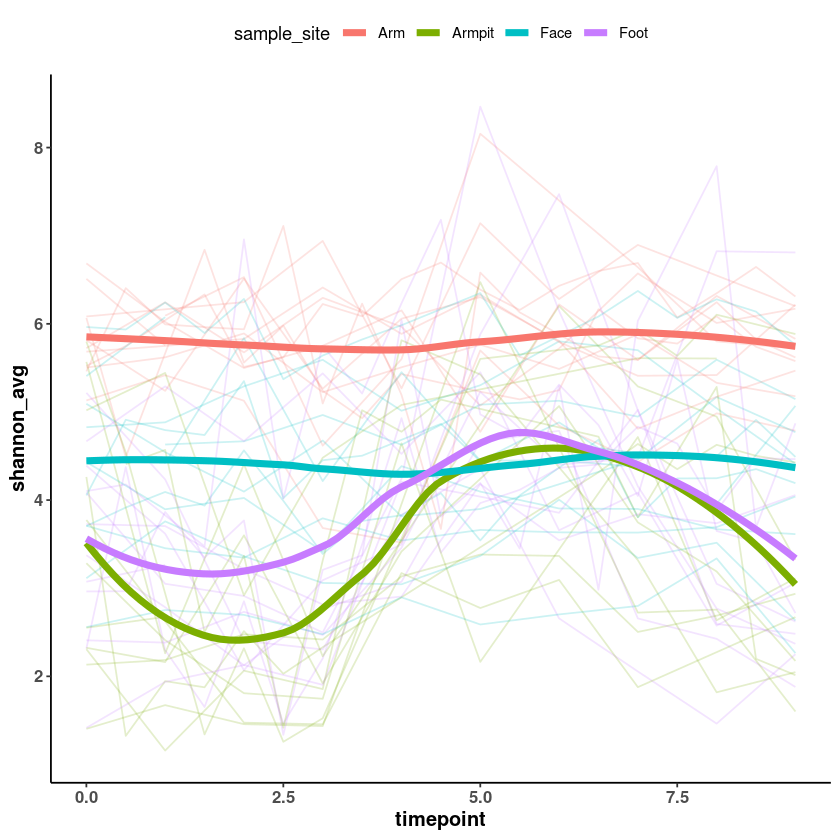

In [4]:
## visualize original data 
plot_group(data = df, time_name = 'timepoint', 
            response_name = 'shannon_avg',
            unique_subject_id = 'ID_unique', variable_name = 'sample_site')$figure

choose approriate transformation of data:
* SFPCA has normal assumptions, so the reponse modeled needs to be normally distributed
* "response" can be transformed response variable, so even if the original measurement is not normally distributed, it can be transformed to be normal, and then use SFPCA for modeling
* 4 typical transformations are included: original, log transform, square root, cube root
* choose the transformation type whose confidence bands cover the data the most

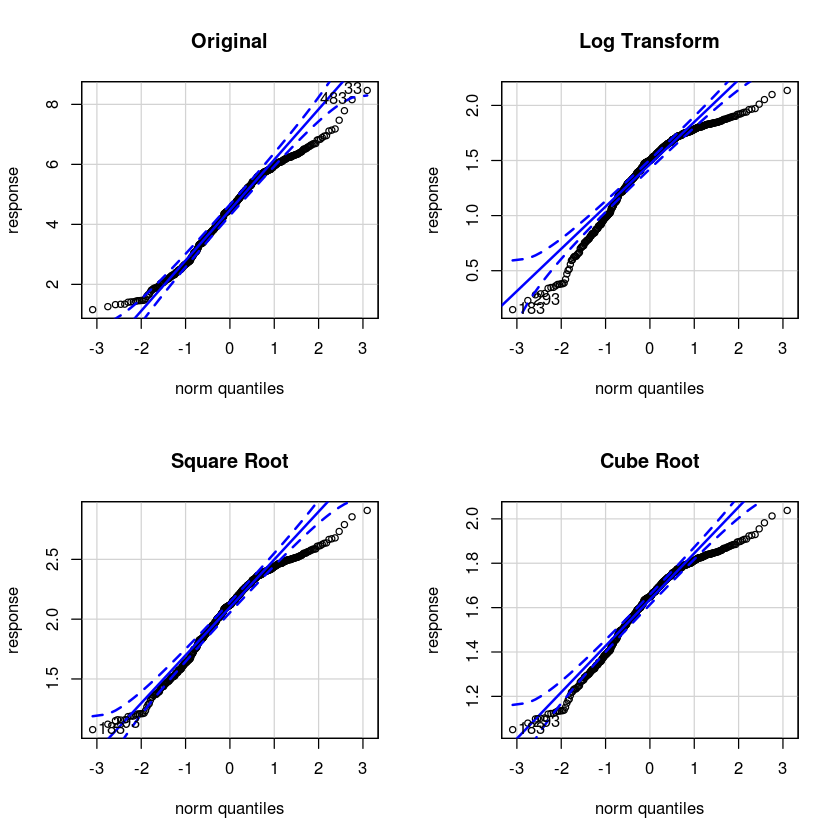

In [5]:
## check necessity of transformation 
plot_qqplot(df, 'shannon_avg')

SFPCA modeling:
* prepare data for SFPCA modeling:
    * response variable will be standardized to have mean zero and standard deviation one
    * time variable will be re-scaled to be in [0,1]
    * the final SFPCA results wil present the results back in their original scale
* Bayesian approach:
    * choose number of samplers and chains in MCMC (Markov chain Monte Carlo)
    * define number of cores for parallel computation
    * define range of PCs and number of internal knots for model selection
    * Bayesian modeling is slow, dependings on the sample size, each model might take 10-30 minutes

In [6]:
## prepare data for SFPCA
dat <- prepare_data(data = df, unique_subject_id = 'ID_unique', time_name = 'timepoint',
                    response_name = 'shannon_avg', transform_y = 'standardize', scale_time = T)

In [7]:
# # SFPCA model fit (commented out: take a while to run)
# sfpca_stan_results <- stan_fit(sfpca_data = dat, Nsamples = 1000, Nchain = 3, Ncores=3, 
#                                PC_range = c(2,3,4), nknot_range = c(2,3,4))
# save(sfpca_stan_results, file='bayesTime_modelSelection.RData') 

# note that change seed doesn't change results
# each computer produce its own result, like kl-kernel & my own mac
# use the results from my own mac and upload to kl-kernel

In [8]:
load('bayesTime_modelSelection.RData')

select optimal model:
* all candidates are ranged from best to worst based on PSIS-LOO criterion
* higher elpd value indicates better model
* if elpd_diff < se_diff, then two models are similarly good 
    * use the following diagnostic methods to help decision
    * check proportion of variance explained by each PC to decide optimal number of PCs

In [9]:
# choose optimal model 
optimal_model_idx <- optimal(model_list = sfpca_stan_results)

        elpd_diff   se_diff pc knot
model8   0.000000  0.000000  4    3
model7  -1.187177  4.392177  4    2
model5  -1.664777  3.953824  3    3
model6  -4.196665  5.344105  3    4
model4  -4.303278  5.523151  3    2
model9  -7.577920  5.835492  4    4
model2 -38.815318 16.113301  2    3
model1 -40.521937 16.250783  2    2
model3 -45.682903 17.066559  2    4


In [10]:
# use default model with highest elpd from PSIS-LOO
optimal_model <- sfpca_stan_results[[optimal_model_idx]]
model_output <- output_results(sfpca_data = dat, model = optimal_model)

two model diagnostics methods:
1. PSIS-LOO k diagnostics: identifying outliers
    * x-axis: index the one subject left out at each fitting
    * y-axis: Pareto shape parameter K values for each leave-one-out fitting
    * subjects with k value > 0.7 treshold are potential outliers or influential curve
    * compare predicted curve with observed curve to examine potential outliers(plot_obs_predict() function)
2. visual posterior checks: model fitting
    * x-axis: standardized response value
    * y-axis: kernel density of observed data (dark curve), and of 100 replicated data based on model (thin curves)
    * check how well the model based data could cover the observed data

[1] "Warning: observation 36 (subject ID Volunteer 6Foot) has Pareto k-values greater than 0.7 at 0.7132"  
[2] "Warning: observation 46 (subject ID Volunteer 9Armpit) has Pareto k-values greater than 0.7 at 1.1495"


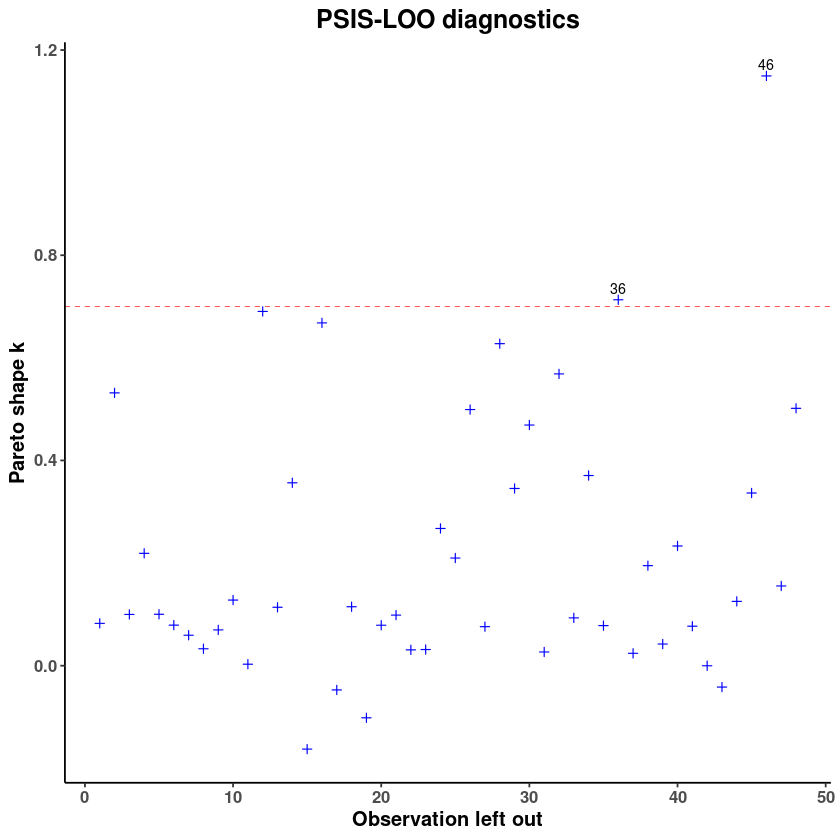

In [11]:
# identify outliers
plot_k_diagnostic(dat, optimal_model)$figure

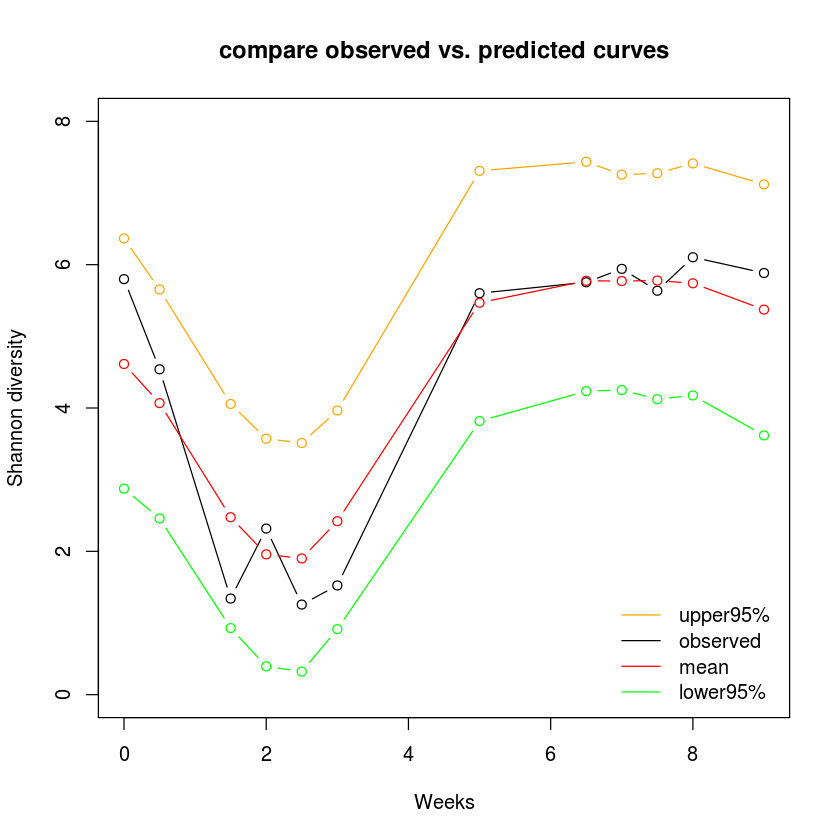

In [12]:
# examine outliers
plot_obs_predict(sfpca_data=dat, optimal_model=optimal_model, data=df, 
                 time_name = 'timepoint', response_name = 'shannon_avg', 
                 unique_subject_id = 'ID_unique', subject_selected='Volunteer 9Armpit',
                 ymin=0, ymax=8, x_lab='Weeks', y_lab='Shannon diversity')

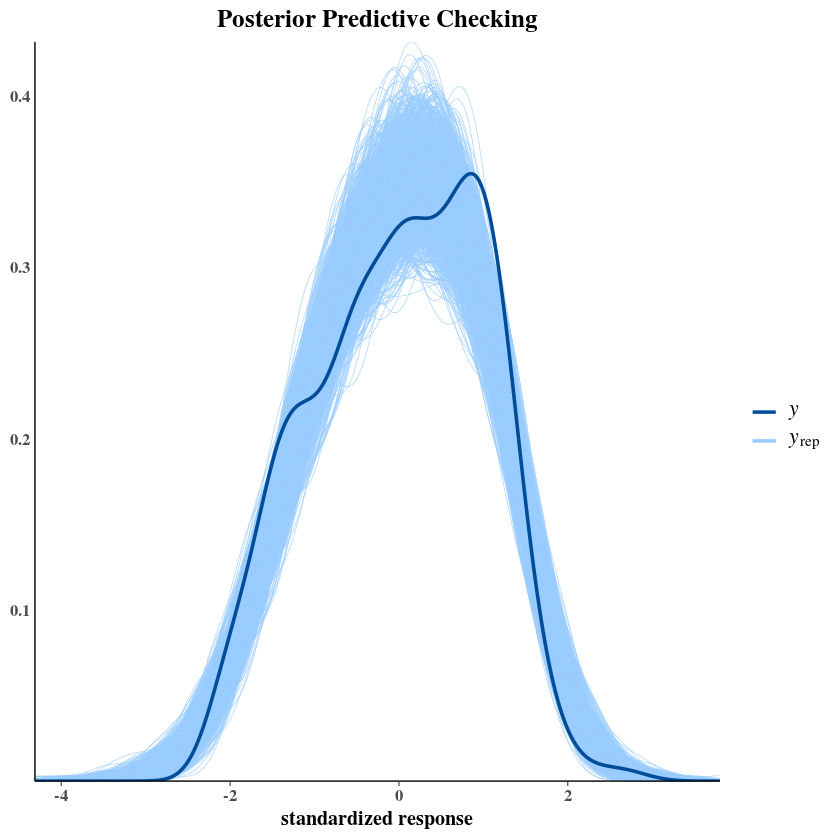

In [13]:
# check model fit
plot_posterior_diagnostic(dat, optimal_model)$figure 

visualize SFPCA results:
* mean curve:
    1. visualize estimated mean curve (global trend) on top of observed curves (plot_mean_curve() function)
* FPC curves: visualize major temporal patterns in subject-level variation not captured by mean curve    
    1. plot estimated FPC curves (plot_fpc_curve() function)
        * visualize FPC cuves
        * visualize which time points are "turning points"
    2. plot effect of FPC curves on mean curves (plot_fpc_on_mean_curve() function)
        * visualize curves of subjects with postivie/negative weights on each FPC curve
        * weights defined as 1 standard deviation of FPC scores
    3. plot estimated curve for interested covariate based on each PC (plot_fpc_group_mean() function)
* FPC scores: weights of each subject on each FPC    
    1. compare group difference based on FPC scores(plot_fpc_boxplot() function)
        * different pairwise tests (two sided student t-test or wilcoxon rank sum test)
        * various multiple comparison adjustment method available
    2. effect size estimation for non-redundant covariate based on FPC scores(effectSize_rda() function)

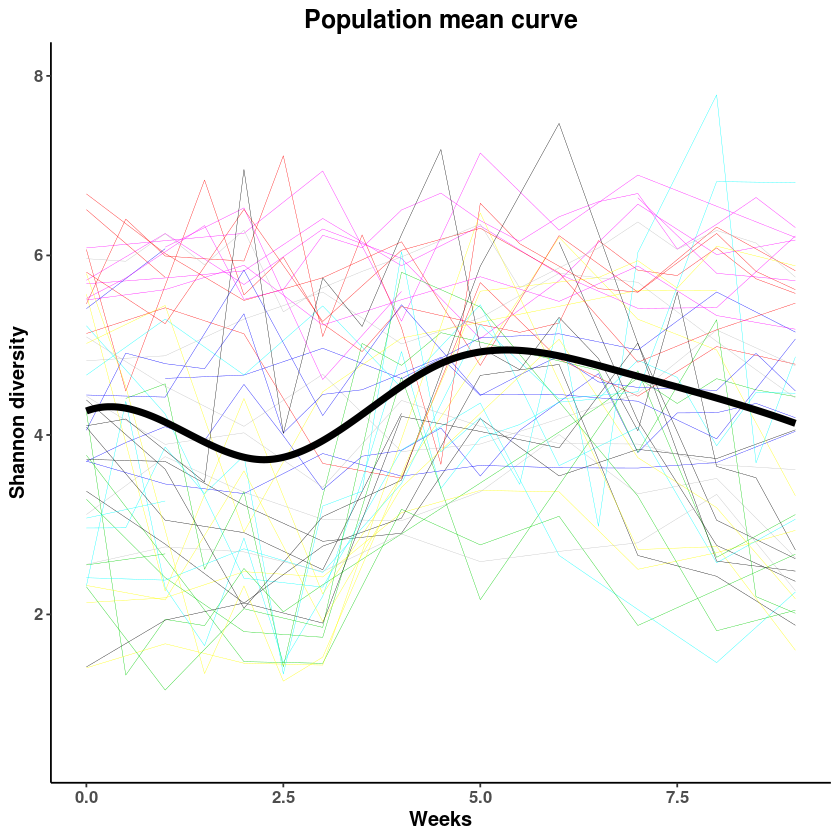

In [14]:
plot_mean_curve(output = model_output, original=T, 
                ymin=0.5, ymax=8, x_lab='Weeks', y_lab='Shannon diversity')$figure

Warning message:
“Removed 448 row(s) containing missing values (geom_path).”


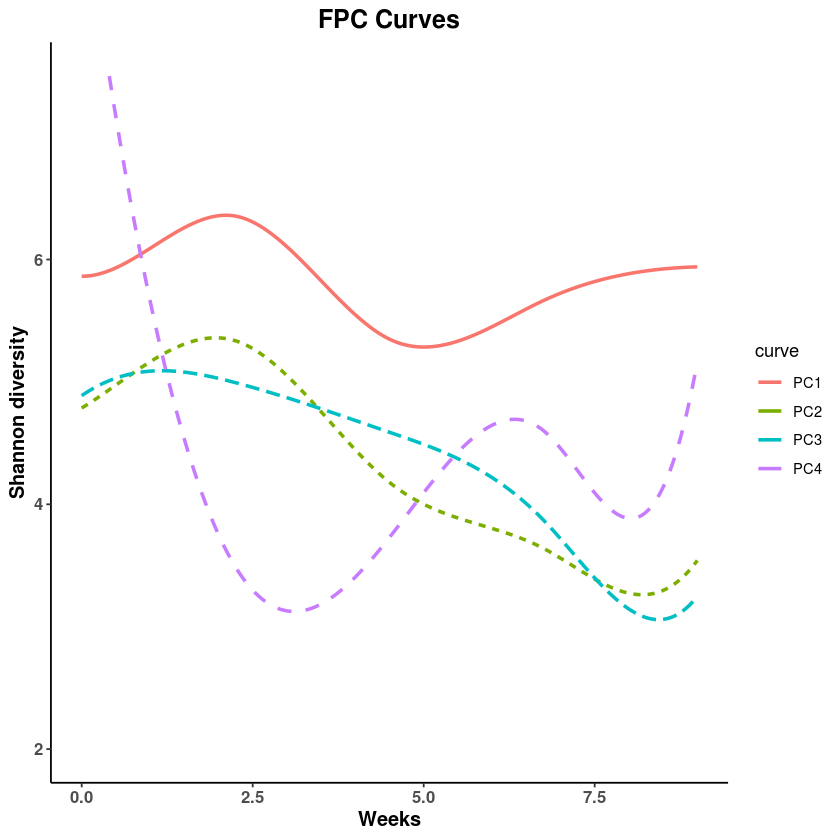

In [15]:
plot_fpc_curve(output = model_output, pc_idx=c(1,2,3,4), ymin=2, ymax=7.5,
               original=T, x_lab='Weeks', y_lab='Shannon diversity')$figure

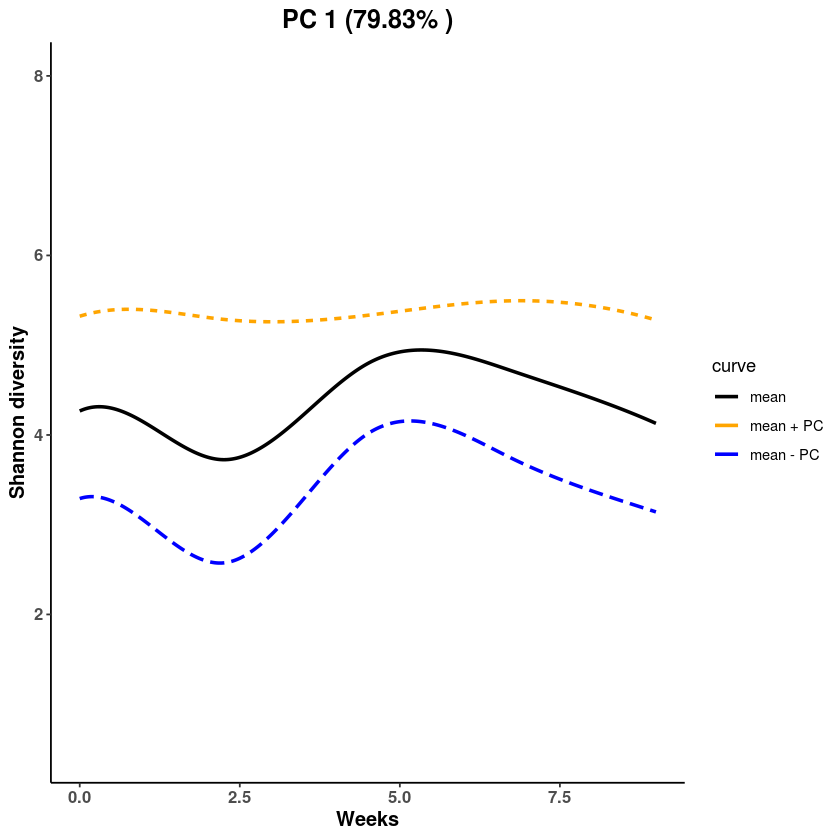

In [16]:
plot_fpc_on_mean_curve(output = model_output, pc_idx=1, original = T, sd=T, 
                       x_lab='Weeks', y_lab='Shannon diversity', ymin=0.5, ymax=8)$figure

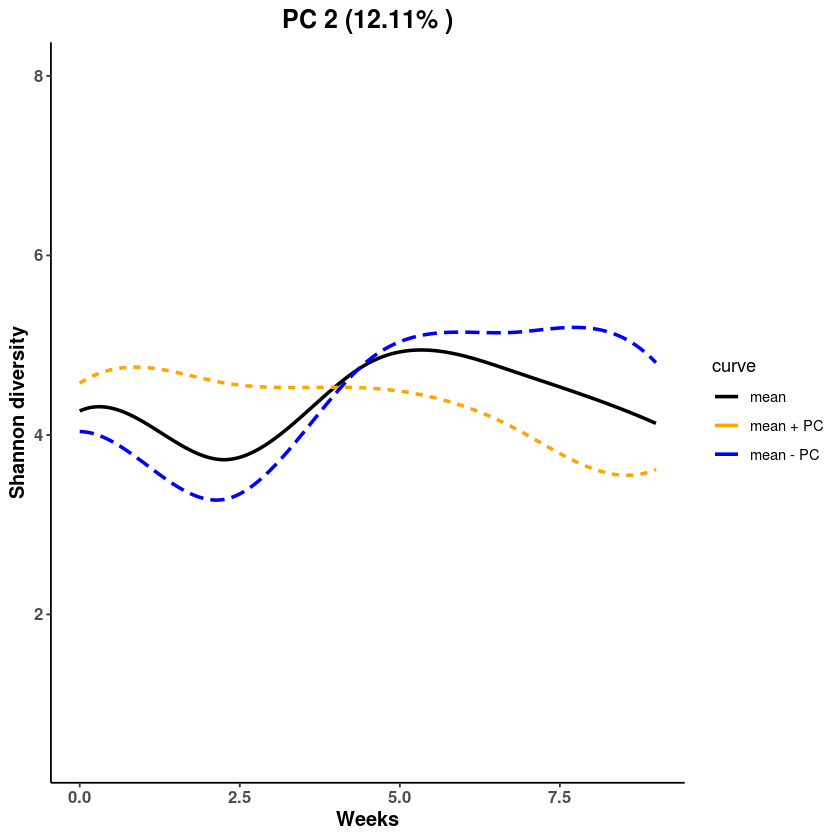

In [17]:
plot_fpc_on_mean_curve(output = model_output, pc_idx=2, original = T, sd=T,
                       x_lab='Weeks', y_lab='Shannon diversity', ymin=0.5, ymax=8)$figure

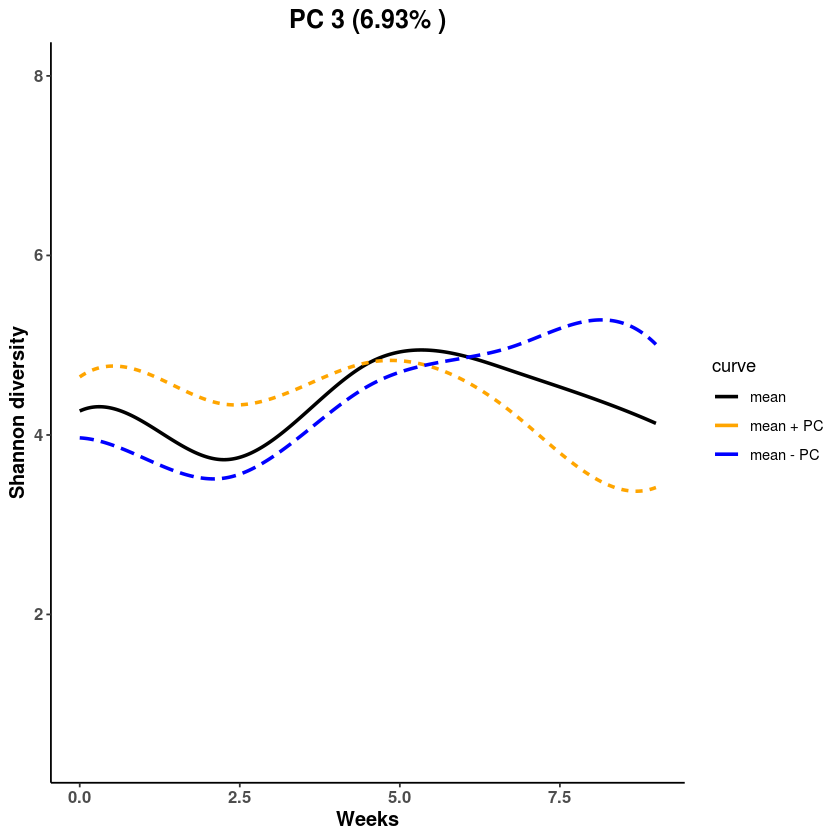

In [18]:
plot_fpc_on_mean_curve(output = model_output, pc_idx=3, original = T, sd=T, 
                       x_lab='Weeks', y_lab='Shannon diversity', ymin=0.5, ymax=8)$figure

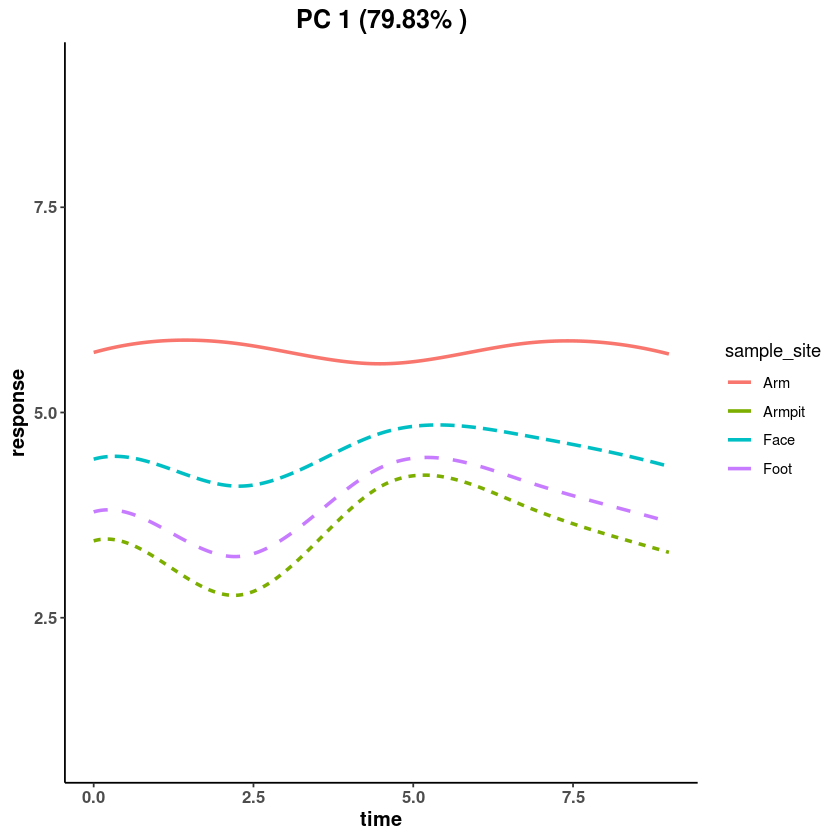

In [19]:
plot_fpc_group_mean(model_output, pc_idx=1, original=T, group_name='sample_site')$figure

`summarise()` ungrouping output (override with `.groups` argument)



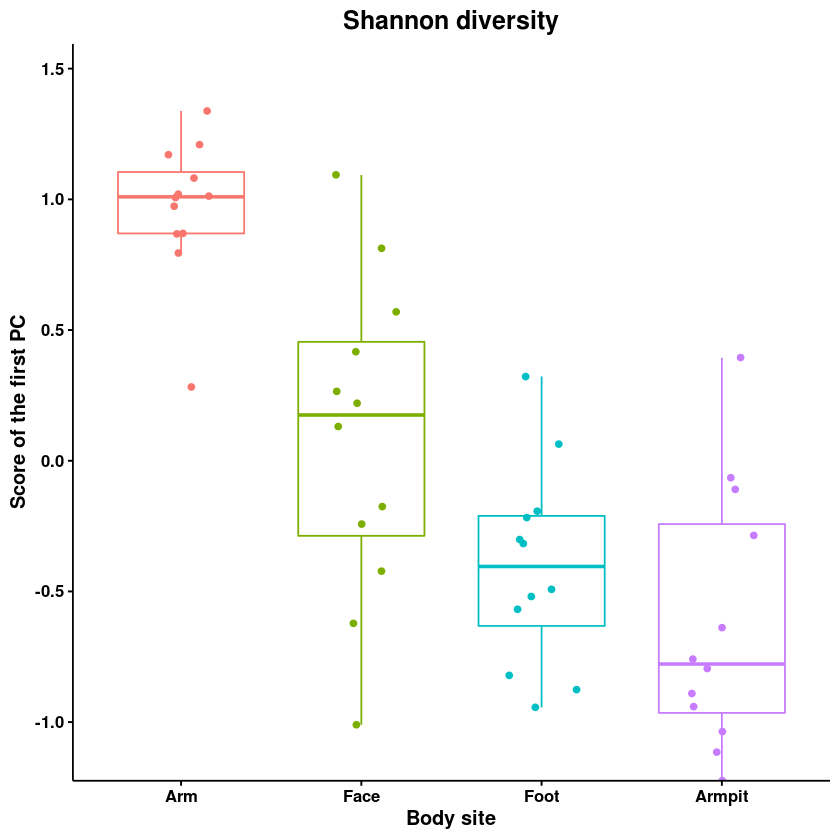

In [20]:
plot_fpc_boxplot(output = model_output, pc_idx=1, group_name = 'sample_site',
                 x_lab = 'Body site', y_lab = 'Score of the first PC', p_title='Shannon diversity',
                 testing_type = 'non-parametric', pairwise_testing=F, pval_show_all=T)$figure 

In [21]:
# identify time non-varying covariates
invars <- invariants(df, 'ID_unique', 'timepoint') 
invars

[1] "subject"     "sample_site" "sex"

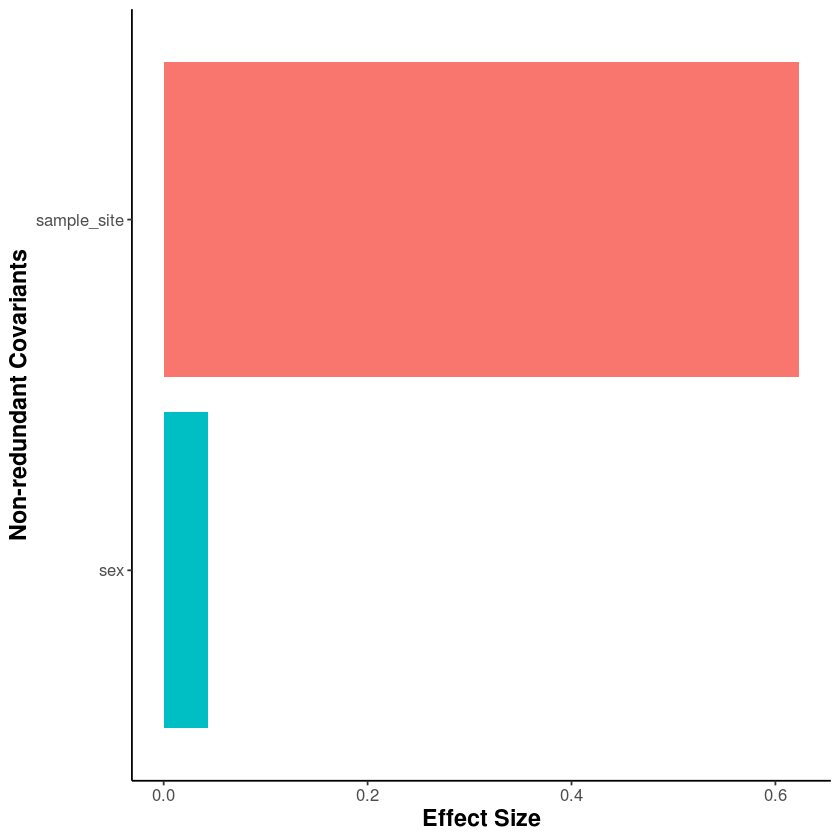

In [22]:
# effect size estimation
model_rda <- effectSize_rda(model_output, optimal_model, c('sample_site', 'sex'))